# Numerics of MD

## Test problem

\begin{align*}
& \min_x \|Ax - b\|_1\\
\text{s.t. } & x \in \Delta
\end{align*}

- Subgradient $g = \sum_{i=1}^m sign(a_i^{\top}x - b) a_i$
- Projected subgradient descent $(\varphi(x) = \frac12\|x\|^2_2)$
$$
x_{k+1} = \arg\min_{x \in \Delta} (\langle g_k, x\rangle + \frac{1}{2\alpha_k}\|x - x_k\|_2^2)
$$
Algorithm for computing projection onto simplex is provided [here](https://arxiv.org/pdf/1101.6081.pdf)
- Entropic descent $(\varphi(x) = \sum_{i=1}^n x_i \log x_i)$
$$
x^i_{k+1} = \frac{x_k^i \exp(-\alpha_k g(x_k)_i)}{\sum_{j=1}^n x_k^j \exp(-\alpha_k g(x_k)_j)}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc("text", usetex=True)
import cvxpy as cvx
from numba import jit

In [35]:
m = 20
n = 3000
A = np.random.randn(m, n)
# x_true = np.random.rand(n)
# x_true = x_true / np.linalg.norm(x_true, 1)
x_true = np.zeros(n)
x_true[0] = 0.5
x_true[1] = 0.5
b = A.dot(x_true) + 0.01 * np.random.randn(m)
# b = 0.5 * (A[:, 0] + A[:, 1])

In [36]:
def entropic_descent(subgrad, x0, step_size=None, max_iter=100):
    x = x0.copy()
    conv = [x]
    for i in range(max_iter):
        g = subgrad(x)
        if step_size is None:
            alpha = 1. / (i + 1)
        else:
            alpha = step_size
        x = x * np.exp(-alpha * g) / np.sum(x * np.exp(-alpha * g))
        conv.append(x)
    return x, conv

In [37]:
def mirror_prox_entropic_descent(subgrad, x0, step_size=None, max_iter=100):
    x = x0.copy()
    conv = [x]
    for i in range(max_iter):
        g = subgrad(x)
        if step_size is None:
            alpha = 1. / (i + 1)
        else:
            alpha = step_size
        y = x * np.exp(-alpha * g) / np.sum(x * np.exp(-alpha * g))
        g_y = subgrad(y)
        x = x * np.exp(-alpha * g_y) / np.sum(x * np.exp(-alpha * g_y))
        conv.append(x)
    return x, conv

In [38]:
def dual_averaging(subgrad, x0, step_size=None, max_iter=100):
    x = x0.copy()
    conv = [x]
    subgrad_average = np.zeros_like(x0)
    for i in range(max_iter):
        g = subgrad(x)
        subgrad_average = i / (i+1) * subgrad_average + g / (i+1)
        if step_size is None:
#             alpha = 1. / np.sqrt(i + 1)
            alpha = 1. / (i + 1)
        else:
            alpha = step_size
        x = x * np.exp(-alpha * subgrad_average) / np.sum(x * np.exp(-alpha * subgrad_average))
        conv.append(x)
    return x, conv

In [39]:
@jit(nopython=True)
def proj(y):
    x = y.copy()
    if np.all(x >= 0) and np.sum(x) <= 1:
        return x
    x[x < 0] = 0
    if np.sum(x) <= 1:
        return x
    n = x.shape[0]
    bget = False
    x.sort()
    x = x[::-1]
    temp_sum = 0
    for i in range(n - 1):
        temp_sum += x[i]
        t_hat = (temp_sum - 1.0) / (i + 1)
        if t_hat >= x[i + 1]:
            bget = True
            break
    if not bget:
        t_hat = (temp_sum + x[n - 1] - 1.0) / n
    return np.maximum(y - t_hat, 0)

In [40]:
def proj_subgrad(subgrad, proj, x0, step_size=None, max_iter=100):
    x = x0.copy()
    conv = [x]
    for i in range(max_iter):
        g = subgrad(x)
        if step_size is None:
            alpha = 1. / (i+1) 
        else:
            alpha = step_size
        x = proj(x - alpha * g)
        conv.append(x)
    return x, conv

In [41]:
x0 = np.ones(n) / n
max_iter = 4000

In [42]:
subgrad = lambda x: np.sum(A.T * np.sign(A.dot(x) - b), axis=1)
f = lambda x: np.linalg.norm(A.dot(x) - b, 1)

In [43]:
step_size_md = None
x_entr, conv_entr = entropic_descent(subgrad, x0, step_size_md, max_iter)
average_conv_entr = np.array(conv_entr)

print(np.linalg.norm(x_entr, 1), f(np.mean(average_conv_entr, axis=0)))
f2plot_entr = [f(np.mean(average_conv_entr[:i, :], axis=0)) for i in range(1, len(conv_entr)+1)]

1.0 0.01068251295549591


In [44]:
step_size_sg = None
x_subgr, conv_projsub = proj_subgrad(subgrad, proj, x0, step_size_sg, max_iter)
print(np.linalg.norm(x_subgr, 1), f(x_subgr))

0.999999999999999 1.5893668229336746


In [45]:
step_da = None
# step_da = None
x_da, conv_da = dual_averaging(subgrad, x0, step_da, max_iter)
average_conv_da = np.array(conv_da)
print(np.linalg.norm(x_da, 1), f(np.mean(average_conv_da, axis=0)))
f2plot_da = [f(np.mean(average_conv_da[:i, :], axis=0)) for i in range(1, len(conv_da)+1)]

0.9999999999999999 0.01652583966922508


In [46]:
step_mp = None
x_mp, conv_mp = mirror_prox_entropic_descent(subgrad, x0, step_mp, max_iter)
average_conv_mp = np.array(conv_mp)
print(np.linalg.norm(x_mp, 1), f(np.mean(average_conv_mp, axis=0)))
f2plot_mp = [f(np.mean(average_conv_mp[:i, :], axis=0)) for i in range(1, len(conv_mp)+1)]

1.0 0.052764614843561194


(array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
 <a list of 8 Text yticklabel objects>)

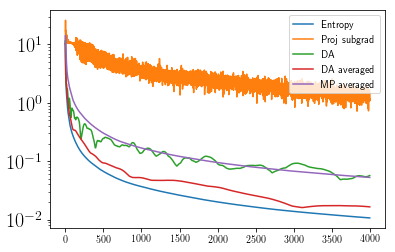

In [47]:
plt.semilogy(f2plot_entr, label="Entropy")
plt.semilogy([f(x) for x in conv_projsub], label="Proj subgrad")
plt.semilogy([f(x) for x in conv_da], label="DA")
plt.semilogy(f2plot_da, label="DA averaged")
plt.semilogy(f2plot_mp, label="MP averaged")
plt.legend()
plt.yticks(fontsize=20)

In [49]:
np.mean(average_conv_da, axis=0), np.mean(average_conv_entr, axis=0)

(array([5.06126825e-03, 1.68793644e-01, 6.73228692e-07, ...,
        9.73724370e-08, 1.31283186e-06, 5.17789620e-04]),
 array([5.10607791e-03, 1.68818523e-01, 6.93119922e-07, ...,
        9.79301621e-08, 1.33849657e-06, 5.24805573e-04]))

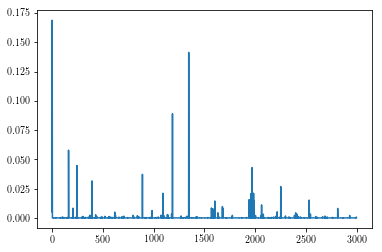

In [52]:
plt.plot(np.mean(average_conv_da, axis=0))

In [56]:
np.sum(abs(np.mean(average_conv_da, axis=0)) > 1e-2)

17